In [1]:
import numpy as np
import argparse
import csv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
np.random.seed(42)
import pandas as pd
import math
import random

In [3]:
LEARNING_RATE = 0.003
BATCH_SIZE = 4
NUM_ITER = 50000
MAX_POWER = 9
SUBSET = 20
SPLIT = 0.9
ERROR = "mse"
REGULARIZATION_LAMBDA = 0

In [4]:
def readDataLink(filename):
    dataset = []
    df = pd.read_csv(filename,header=None)
    for i,row in df.iterrows():
        dataset.append([float(row[0]),float(row[1])])
    return dataset
dataset = readDataLink('https://web.iitd.ac.in/~sumeet/A1/2019EE10577/gaussian.csv')

In [57]:
def readData(filename):
    dataset = []
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            dataset.append([float(row[0]),float(row[1])])
    return dataset
dataset = readData('gaussian.csv')

In [5]:
dataset = dataset[:SUBSET]

In [6]:
# highest power is m here
def makeDesignMat(x,m):
    return np.vander(x,m+1,increasing=True)

In [7]:
def chunkarr(arr,n):
    return [arr[i:i + n] for i in range(0, len(arr), n)]

In [8]:
def plot_error(train_err_list,test_err_list):
    xa = np.linspace(1,len(train_err_list),len(train_err_list),dtype=int)
    plt.figure()
    plt.plot(xa,train_err_list,color="g")
    plt.plot(xa,test_err_list,color="r")
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Error vs Iterations')
    plt.show()

In [9]:
def descent(trainX,y,testX,testY,lambd = 0.0, err_function = "mse" ):
    w = np.zeros(MAX_POWER+1)
    bestw = np.zeros(MAX_POWER+1)
    y = np.array(y)
    X = makeDesignMat(trainX,MAX_POWER)
    Xchunks = chunkarr(X,BATCH_SIZE)
    ychunks = chunkarr(y,BATCH_SIZE)
    train_err_list = []
    test_err_list = []
    lr = LEARNING_RATE
    flag = False
    for j in tqdm(range(NUM_ITER)):
        preverr = testError(trainX,y,w,MAX_POWER)
        for chunk in range(len(Xchunks)):
            Xcon = Xchunks[chunk]
            ycon = ychunks[chunk]
            pred = np.dot(Xcon,w)
            test_err_list.append(testError(testX,testY,w,MAX_POWER))
            if err_function == "mse":
                err = 0.5 * (np.sum(np.square(pred-ycon)) + lambd*np.sum(np.square(w)))/len(ycon)
                #grad = (np.dot(Xcon.T,(pred-ycon)) + lambd*w)/len(ycon)
                grad = (np.dot(Xcon.T,(pred-ycon)) + lambd*w)
                grad /= np.linalg.norm(grad)
            if err_function == "mae":
                err = np.sum(np.abs(pred-ycon))
                parity = np.sign(pred - ycon)
                parity = parity.reshape((len(ycon),1))
                grad = np.sum(np.multiply(parity,Xcon).T,axis=1)/len(ycon)
            if err_function == "huber":
                e = 0.1
                temp = pred-ycon
                err = np.sum(np.where(np.abs(temp)<=e,0.5*temp*temp,(e*np.abs(temp) - 0.5*e*e)))
                err += lambd*np.sum(np.square(w))
                err /= len(ycon)
                grad = np.zeros((MAX_POWER+1,))
                for i in range(len(ycon)):
                    if np.abs(temp[i]<=e):
                        grad += temp[i]*Xcon[i,:]
                    else:
                        grad += e*np.sign(temp[i])*Xcon[i,:]
                grad+=2*lambd*w
                w = np.squeeze(w)
                grad /=len(ycon)
                grad = np.squeeze(grad)
            w = w - lr * grad
            train_err_list.append(err)
        newerr = testError(trainX,y,w,MAX_POWER)
        if(j%5000==0):
            print(newerr)
#         if(newerr<0.03):
#             continue
        #lr = LEARNING_RATE * math.exp(-0.0015*j/NUM_ITER)
    
    plot_error(train_err_list,test_err_list)
    return w

In [10]:
def plot_reg(trainX,trainY,testX,testY,w):
    def aux(X_line,w):
        temp = 0
        for i in range(len(w)):
            temp += np.power(X_line,i) * w[i]
        return temp
    jointX = np.concatenate((trainX,testX))
    plt.clf()
    plt.scatter(trainX,trainY,color='b',marker ='o',s=15)
    plt.scatter(testX,testY,color="m",marker='o',s=30)
    x_line = np.linspace(min(jointX),max(jointX),100)
    y_pred = aux(x_line,w)
    plt.plot(x_line,y_pred, color='g')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.savefig(f"Grad descent with m={MAX_POWER}.png",dpi=1200)
    plt.show()
    return plt

In [11]:
def testError(X, Y,w,MAX_POWER):
    X = makeDesignMat(X,MAX_POWER)
    pred = np.dot(X,w)
    if ERROR == "mse":
        err = 0.5 * (np.sum(np.square(pred-Y)))/len(Y)
    elif ERROR == "mae":
        err = np.sum(np.abs(pred-Y)) / len(Y)
    elif ERROR == "huber":
        e = 0.1
        temp = pred-Y
        err = np.sum(np.where(np.abs(temp)<=e,0.5*temp*temp,(e*np.abs(temp) - 0.5*e*e))) / len(Y)
    return err

In [12]:
def evaluate(dataset):
    dataset = np.array(dataset)
    numtr = int(SUBSET * SPLIT)
    trainX = dataset[:,0][:numtr]
    trainY = dataset[:,1][:numtr]
    testX = dataset[:,0][numtr:]
    testY = dataset[:,1][numtr:]
    w = descent(trainX,trainY,testX,testY,REGULARIZATION_LAMBDA,ERROR)
    print(f"weights are: {w}")
    plot_reg(trainX,trainY,testX,testY,w)
    trainerr = testError(trainX,trainY,w,MAX_POWER)
    testerr = testError(testX,testY,w,MAX_POWER)
    return trainerr,testerr

7.53816082320203
0.0030860596733158045
0.0030860596733158045
0.0030860596733158045
0.0030860596733158045
0.0030860596733158045
0.0030860596733158045
0.0030860596733158045
0.0030860596733158045
0.0030860596733158045



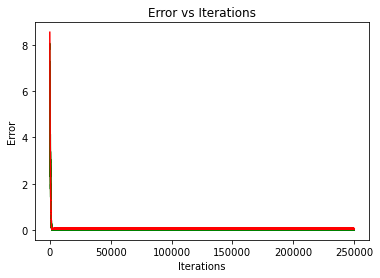

weights are: [ 4.02864444  0.12158773 -0.04201301 -0.13682597]


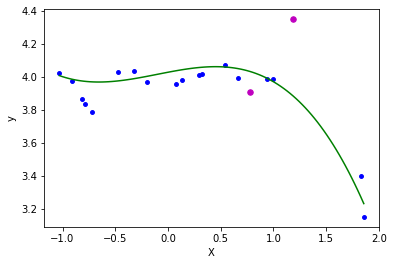

7.512401481281482
0.00326981996026105
0.00326995791624164
0.003269957984963589
0.0032699579849973545
0.003269957984997392
0.0032699579849973523
0.003269957984997352
0.003269957984997352
0.0032699579849973593



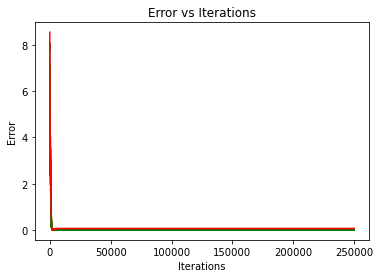

weights are: [ 4.03560768  0.15361146 -0.082469   -0.16957737  0.03196034]


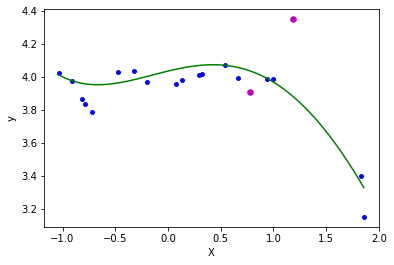

7.494277417233588
0.002838957970303674
0.0026401446612285356
0.002618928443112033
0.002711532048975266
0.0026796540481086
0.0026564569427480547
0.0027071601908646254
0.002800188218296107
0.002766017316662845



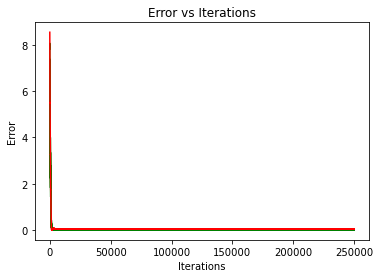

weights are: [ 4.04796357 -0.02189862 -0.20605762  0.15601966  0.16513756 -0.13913355]


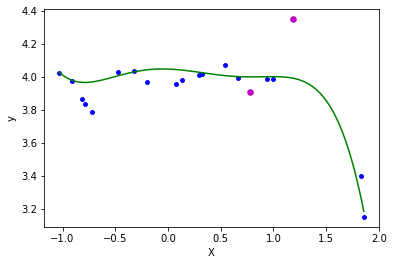

7.420791577741651
0.0040700268880243485
0.004507188818560392
0.007197165368921186
0.0080615935631164
0.008069095559067346
0.006362747776299471
0.006064355129519471
0.007785895958576546
0.0077356703809964966



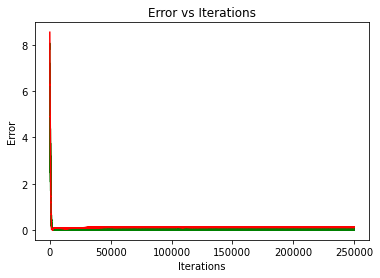

weights are: [ 4.00338664 -0.0508904   0.33026402  0.42885506 -0.67729068 -0.41380123
  0.31656861]


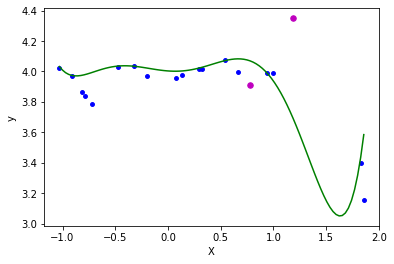

7.3508382286421545
0.005682971334201468
0.005131083668783191
0.004942093739102284
0.008933199393539011
0.004608852166629345
0.00832051457272521
0.00506223094651288
0.010163596480705901
0.0064769600855581625



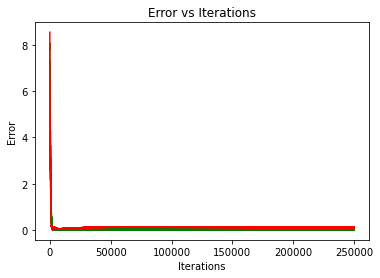

weights are: [ 3.99675073 -0.04865559  0.39099409  0.37505018 -0.79285797 -0.316428
  0.37685666 -0.04192637]


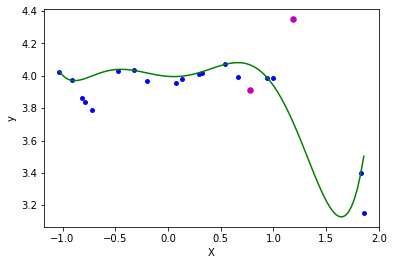

7.174501275101311
0.02895545162848649
0.0061083157029668276
0.005029347213705795
0.009579554564890663
0.007852250274223073
0.003064438321475011
0.002907524985680638
0.00526472603659933
0.005036241663292417



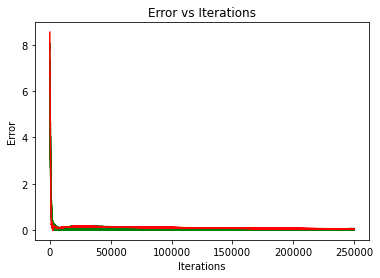

weights are: [ 3.99753948 -0.07555912  0.40988464  0.72987217 -1.2272683  -1.09171452
  1.12924536  0.41535502 -0.32605455]


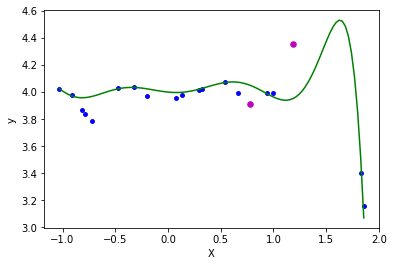

7.041591947760704
0.009252052944550906
0.004239924602237977
0.0031438646936973007
0.003059936976692785
0.002816330487845545
0.004121913364214815
0.012377435234434912
0.004008832537290961
0.03193978462290819



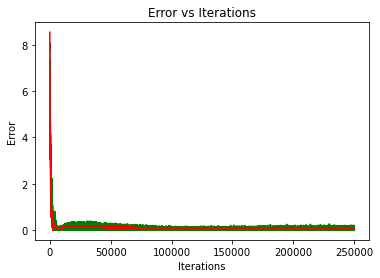

weights are: [ 3.99883401 -0.0682333   0.38966893  0.6611224  -1.0011519  -1.02353755
  0.72997193  0.48689921 -0.12984636 -0.08067066]


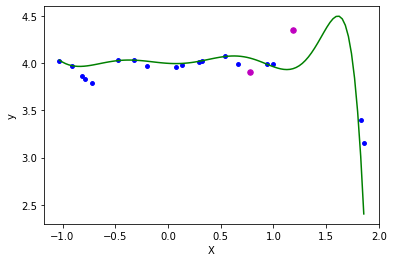

7.064795406143215
0.017983827921379883
0.06335170263497734
0.09228311468043554
0.053747069616603055
0.058550067333238545
0.08317502541560555
0.09788578079832816
0.15125713623429732
0.16316620590051212



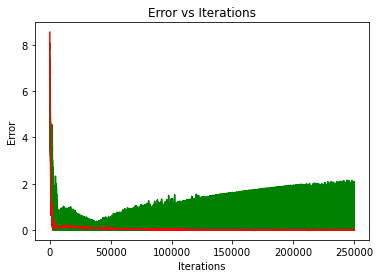

weights are: [ 4.00971861 -0.11179547  0.28090712  1.04473552 -0.98981743 -1.11310393
  0.50904396 -0.56391826  0.69240285  0.7294307  -0.49126897]


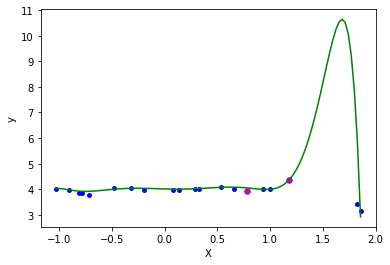

In [13]:
minerr = 999999
bestdeg = 0
testerrs = []
trainerrs = []
for MAX_POWER in range(3,11):
    trainerr,testerr = evaluate(dataset)
    testerrs.append(testerr)
    trainerrs.append(trainerr)
    if trainerr<minerr:
        minerr = trainerr
        bestdeg = MAX_POWER

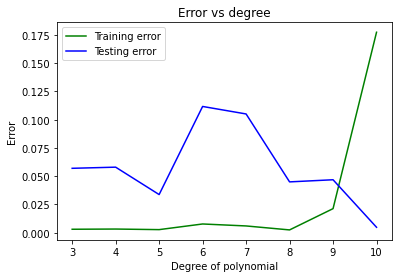

In [14]:
plt.clf()
plt.plot(np.arange(3,11),trainerrs,color='g',label = "Training error")
plt.plot(np.arange(3,11),testerrs,color='b',label = "Testing error")
plt.xlabel('Degree of polynomial')
plt.ylabel('Error')
plt.title('Error vs degree')
plt.legend()
plt.savefig(f"GD Error vs degree.png",dpi=1200)
plt.show()

6.973226056177941
0.00437233547351477
0.002974142246218252
0.0014512785662781416
0.0075622380623641145
0.002477650482164143
0.017100124578020192
0.003572439151760235
0.008961669388523073
0.005282050298149477



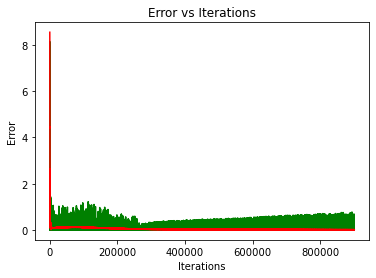

weights are: [ 3.95080176e+00  4.08830880e-04  9.01787391e-01  1.93196215e-01
 -2.56315959e+00  1.06475245e-01  1.93891514e+00 -2.74184424e-01
 -2.53400555e-01]


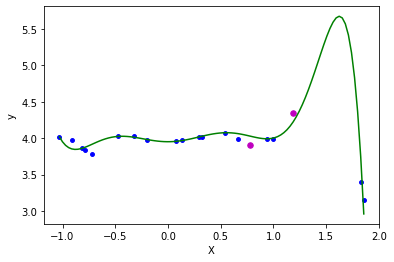

7.174501275101311
0.02895545162848649
0.0061083157029668276
0.005029347213705795
0.009579554564890663
0.007852250274223073
0.003064438321475011
0.002907524985680638
0.00526472603659933
0.005036241663292417



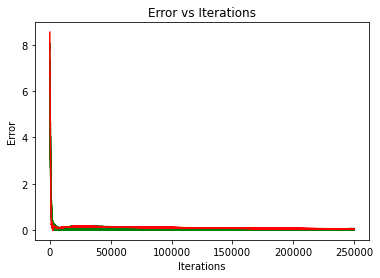

weights are: [ 3.99753948 -0.07555912  0.40988464  0.72987217 -1.2272683  -1.09171452
  1.12924536  0.41535502 -0.32605455]


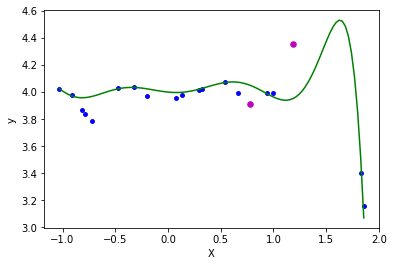

7.33139440764027
0.008059060969271413
0.005570443239928851
0.002688326627017534
0.010565130846676676
0.0025786389544709635
0.007819753824566332
0.00246743028016984
0.002897917938950193
0.0027988308989557115



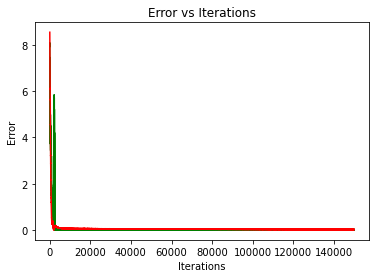

weights are: [ 4.00769274 -0.06324856  0.17222324  0.71093897 -1.01716624 -1.06179476
  1.18786524  0.40792198 -0.35595766]


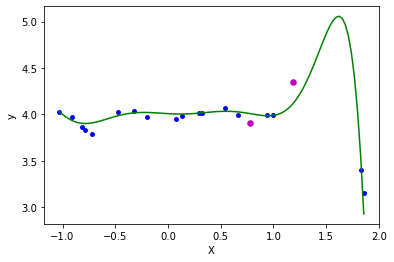

7.442441800482454
0.1224807749536715
0.03112263800451081
0.013605347601375925
0.00968142800669299
0.008456109423812856
0.007816417466862617
0.007344085987873613
0.006950140066695357
0.006610791329481057



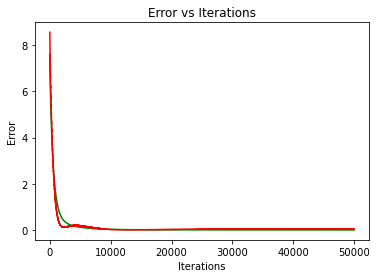

weights are: [ 3.93789784e+00  1.07672219e-01  1.74978216e-01 -5.74064399e-02
 -1.00654924e-01 -3.92628808e-02 -2.46118473e-02  3.48702648e-02
 -3.18189094e-03]


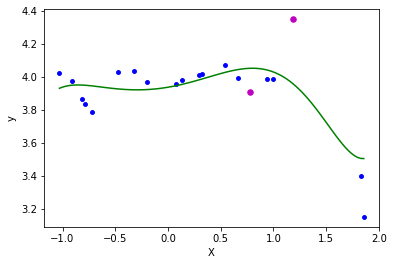

In [15]:
minerr = 999999
bestbs = 0
testerrs = []
trainerrs = []
MAX_POWER = 8
for BATCH_SIZE in [1,4,8,18]:
    trainerr,testerr = evaluate(dataset)
    testerrs.append(testerr)
    trainerrs.append(trainerr)
    if trainerr<minerr:
        minerr = trainerr
        bestbs = BATCH_SIZE

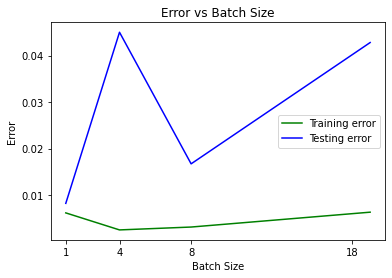

In [17]:
plt.clf()
ax = plt.axes()

plt.plot([1,4,8,18],trainerrs,color='g',label = "Training error")
plt.plot([1,4,8,18],testerrs,color='b',label = "Testing error")
plt.xlabel('Batch Size')
plt.ylabel('Error')
plt.xticks([1,4,8,17],('1','4','8','18'))
plt.title('Error vs Batch Size')
plt.legend()
plt.savefig(f"GD Error vs batch size.png",dpi=1200)
plt.show()

7.33139440764027
0.008389904843142374
0.007872741552975526
0.0030477329366302383
0.003248650311924117
0.008352365896076084
0.002031506681954627
0.010446923740737142
0.002216590285590084
0.014948272013721613



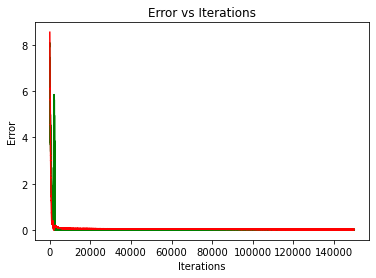

weights are: [ 4.0061132  -0.06583676  0.17376076  0.71207549 -1.01755618 -1.06094108
  1.18885031  0.40840916 -0.35672224]


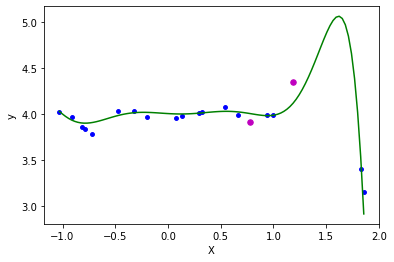

7.33139440764027
0.0036617580383427138
0.0053817710195307985
0.00741439711626897
0.008057991075930205
0.0012797931256812117
0.001529003147904871
0.01065326553002221
0.014852123601006061
0.0029085335510037127



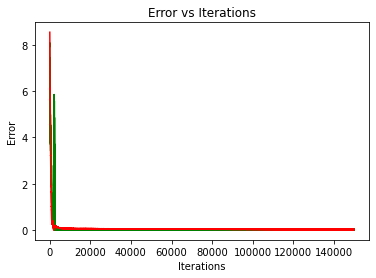

weights are: [ 4.00399658 -0.06023467  0.18232078  0.70418947 -1.02513308 -1.06144508
  1.18709717  0.40856253 -0.35757698]


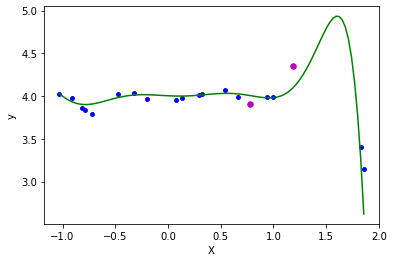

7.331394407640273
0.002454025172968143
0.00884551737877776
0.0030748601236834493
0.008653779935206609
0.0015399966898008175
0.001855599123572586
0.0018750189178941116
0.0026626495461468426
0.0026177792895177693



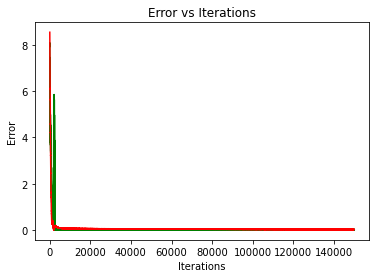

weights are: [ 4.00703276 -0.06627157  0.17092883  0.7127113  -1.01435979 -1.05892037
  1.18862386  0.40769679 -0.35332796]


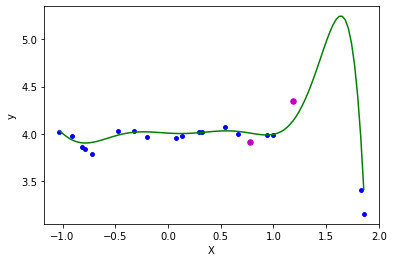

7.331394407640299
0.007484739121865556
0.005174292890136798
0.004194224293466501
0.008943587828188732
0.0013641241715326253
0.0028121386535034216
0.011356080459660845
0.0022534616271504665
0.015993360536507226



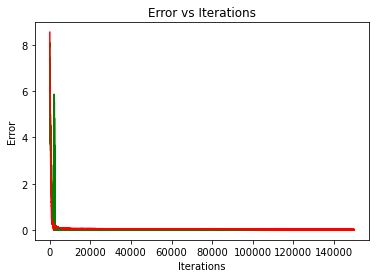

weights are: [ 4.00869823 -0.06072799  0.17250603  0.71227349 -1.01626531 -1.06668994
  1.18807678  0.41042391 -0.35415758]


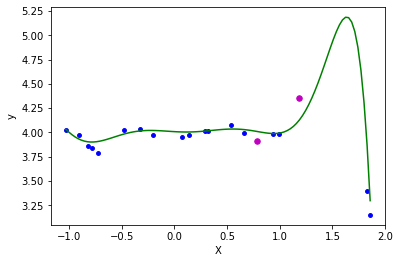

7.331394407640548
0.003180439771726281
0.0056703369479887316
0.0017953844368986038
0.002551087021045474
0.0023917852341304585
0.013496593626189693
0.0022310071390806378
0.0027319563508574314
0.0027458094328159637



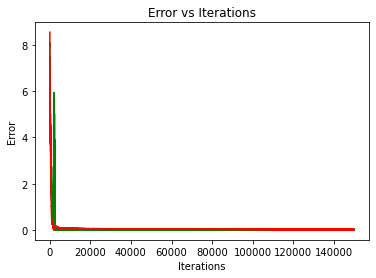

weights are: [ 4.00704173 -0.06280754  0.17458827  0.70841238 -1.02005076 -1.05861061
  1.18914957  0.4081122  -0.35236109]


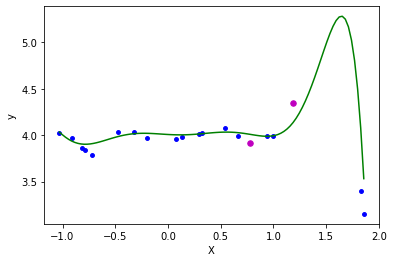

7.3313944076430495
0.013483850589834166
0.007419691267289891
0.009754916632490325
0.003588148154503361
0.002039629786322188
0.00949576495551878
0.0019603326314304318
0.011322480983929295
0.003763083890030623



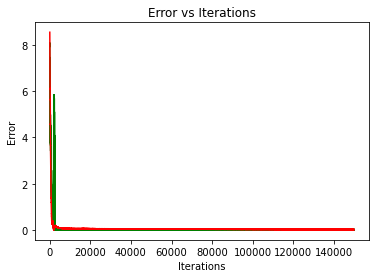

weights are: [ 4.00755825 -0.06290511  0.17321132  0.71042465 -1.01859484 -1.06251485
  1.19039244  0.41028323 -0.35374896]


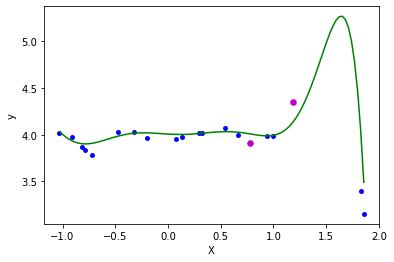

7.331394407668068
0.0070634538751313475
0.0023062583088971213
0.002653104428052015
0.0022239245221890563
0.006096685244539864
0.001674786676424139
0.011589214647676656
0.014509195743484348
0.0030708547834105405



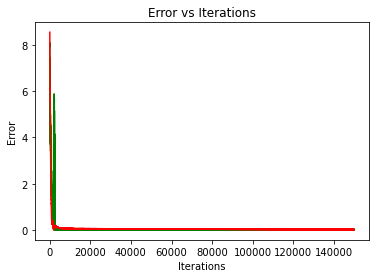

weights are: [ 4.0063533  -0.06585576  0.16961842  0.71605169 -1.00987111 -1.06648617
  1.18458326  0.41098975 -0.3523598 ]


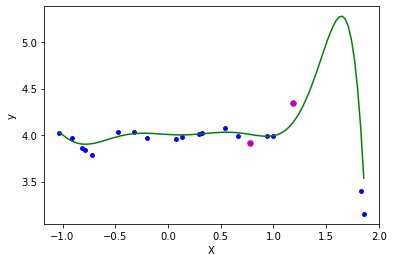

7.33139440791825
0.005643902612677218
0.0038262269502979483
0.004305602555993256
0.006580745765222904
0.0015360958018049765
0.00462336576019903
0.012008086392831446
0.015875416437135078
0.01150413895225615



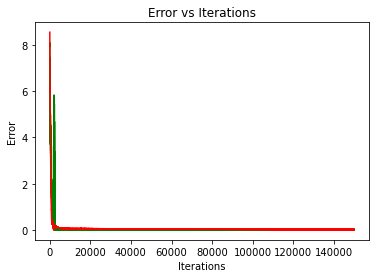

weights are: [ 4.0059699  -0.06284045  0.17156438  0.69792834 -1.00174403 -1.03514298
  1.16492164  0.39358334 -0.34648836]


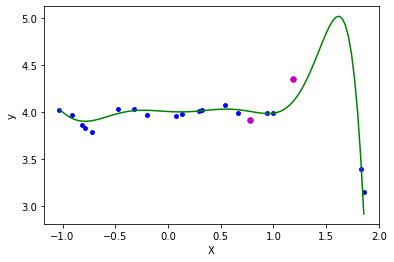

7.331394410420062
0.007776189552770898
0.003063838889707797
0.005511787079067214
0.004195693694676051
0.005588116403024281
0.00941259218225649
0.0017343685401471926
0.004165126998486102
0.0019308515518423257



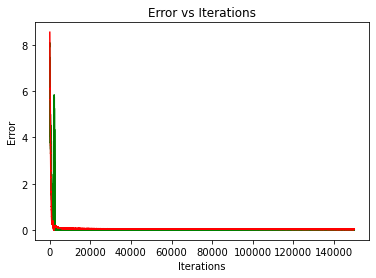

weights are: [ 4.00725693 -0.04464522  0.15450512  0.58681776 -0.87851286 -0.8258064
  0.97779842  0.27863782 -0.26458154]


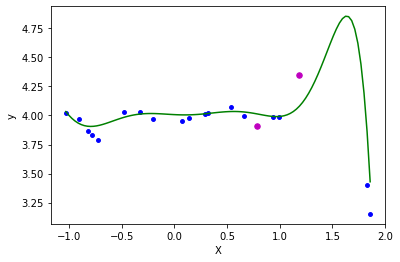

7.331394435438197
0.0031423730897619452
0.0028753210799373065
0.0057788978272645735
0.004302673915247889
0.0032939704232969273
0.0044749969835746785
0.008308670425505956
0.006777197373681493
0.007100125289018425



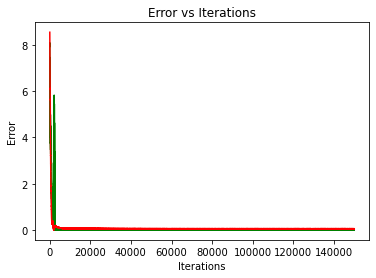

weights are: [ 4.00865906  0.02066451  0.0600479   0.21943018 -0.39010837 -0.17965266
  0.31995671 -0.0680638  -0.01034734]


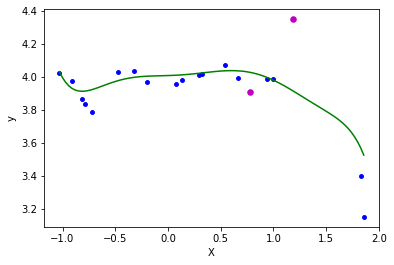

7.331394685620371
0.005015642700929351
0.00757540949428059
0.012592957483184498
0.009323172404914266
0.003346765799210495
0.005501792090844591
0.003656497544356808
0.004732938342932509
0.018990423122041952



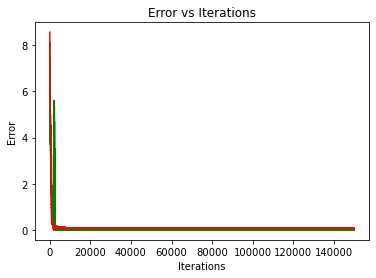

weights are: [ 3.95209866e+00  1.16489332e-01  1.15135231e-01  9.41920360e-03
 -1.40427029e-01 -6.67048593e-02 -2.11561019e-03 -7.62664670e-02
  5.53942833e-02]


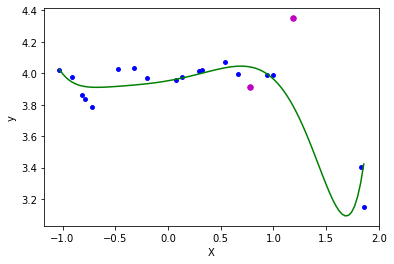

7.331397187524719
0.01078288322995206
0.010783427344385867
0.010783427344836064
0.010783427344836064
0.010783427344836064
0.010783427344836064
0.010783427344836064
0.010783427344836064
0.010783427344836064



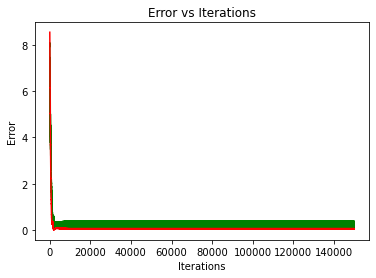

weights are: [ 3.80645786  0.13157526  0.2750713  -0.03836867 -0.0529509  -0.07097905
 -0.06297857 -0.02336825  0.03896342]


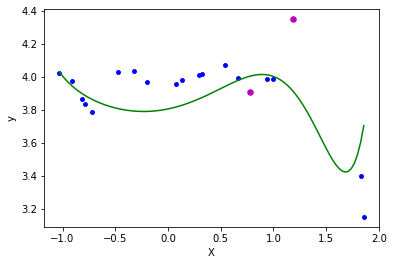

In [18]:
minerr = 999999
bestlambd = 0
testerrs = []
trainerrs = []
MAX_POWER = 8
BATCH_SIZE = 8
for REGULARIZATION_LAMBDA in [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]:
    trainerr,testerr = evaluate(dataset)
    testerrs.append(testerr)
    trainerrs.append(trainerr)
    if trainerr<minerr:
        minerr = trainerr
        bestlambd = REGULARIZATION_LAMBDA

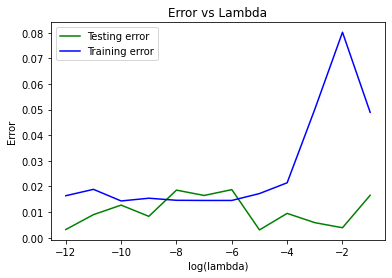

In [19]:
plt.clf()
plt.plot(np.arange(-12,0),trainerrs,color='g',label = "Testing error")
plt.plot(np.arange(-12,0),testerrs,color='b',label = "Training error")
plt.legend()
plt.xlabel("log(lambda)")
plt.ylabel("Error")
plt.title("Error vs Lambda")
plt.savefig('GD Error vs Lambda.png',dpi=1200)
plt.show()

7.33139440764027
0.008059060969271413
0.005570443239928851
0.002688326627017534
0.010565130846676676
0.0025786389544709635
0.007819753824566332
0.00246743028016984
0.002897917938950193
0.0027988308989557115



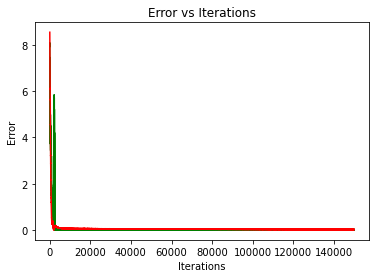

weights are: [ 4.00769274 -0.06324856  0.17222324  0.71093897 -1.01716624 -1.06179476
  1.18786524  0.40792198 -0.35595766]


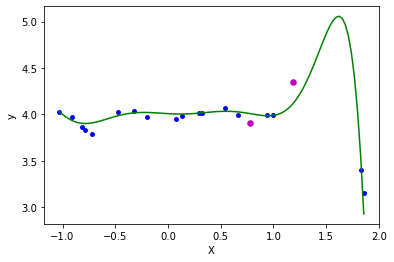

(0.0031200875638770853, 0.016709989627100335)

In [20]:
BATCH_SIZE = 8
MAX_POWER = 8
REGULARIZATION_LAMBDA = 0
evaluate(dataset)

In [128]:
def evaluate_moorepenrose(dataset,MAX_POWER):
    folds = cross_validation_split(dataset)
    err_list = []
    best_testerr = 99999999
    corr_trainerr = 9999999
    bestw = []
    for j,fold in enumerate(folds):
        trainDS = list(folds)
        trainDS.remove(fold)
        trainDS = np.array(trainDS)
        trainX = []
        trainY = []
        for i in range(len(trainDS)):
            trainX.extend(trainDS[i][:,0])
            trainY.extend(trainDS[i][:,1])
        testDS = np.array(fold)
        testX = testDS[:,0]
        testY = testDS[:,1]
        X = makeDesignMat(trainX,MAX_POWER)
        #w = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),np.dot(X.transpose(),trainY))
        w = np.dot(np.linalg.inv(np.dot(X.transpose(),X) + REGULARIZATION_LAMBDA * np.identity(MAX_POWER+1) ),np.dot(X.transpose(),trainY))
        plt = plot_reg(trainX,trainY,testX,testY,w)
        plt.title(f"Moore Penrose with m={MAX_POWER}")
#         if j==0:
#             plt.savefig(f"Moore Penrose with m={MAX_POWER}.png",dpi=1200)
        trainerr = testError(trainX,trainY,w,MAX_POWER)
        testerr = testError(testX,testY,w,MAX_POWER)
        if testerr<best_testerr and trainerr<testerr:
            best_testerr = testerr
            corr_trainerr = trainerr
            bestw = w
        #err_list.append([trainerr,testerr])
    #err_list = np.array(err_list)
    #avg_trainerror = np.mean(err_list[:,0])
    #avg_testerror = np.mean(err_list[:,1])
    #print(w)
    #print(err_list)
    return bestw,best_testerr,corr_trainerr

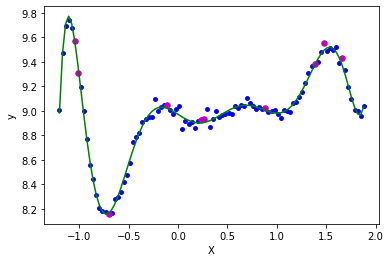

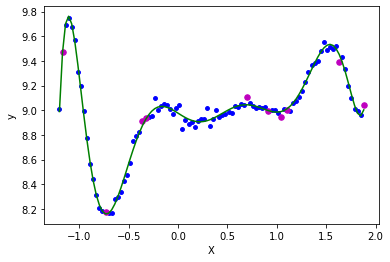

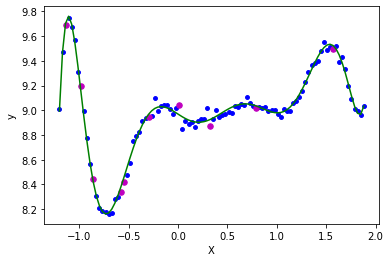

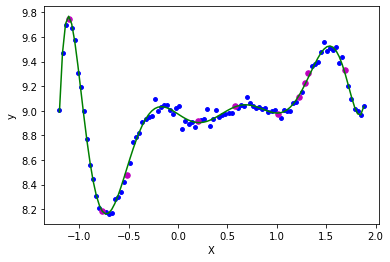

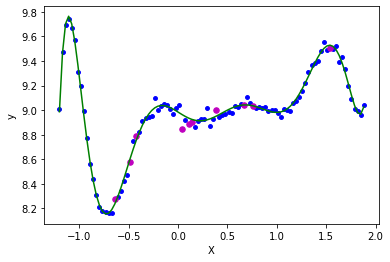

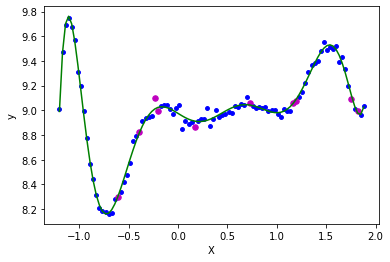

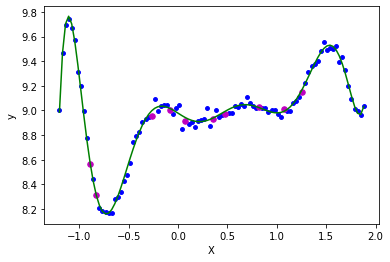

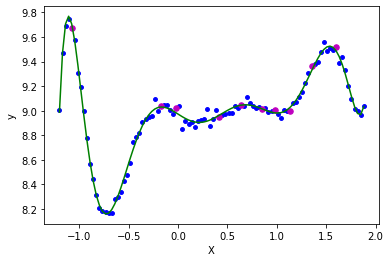

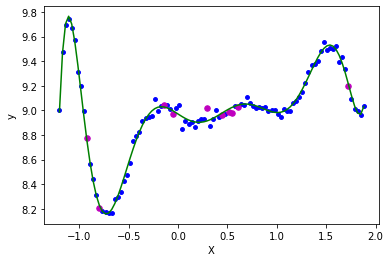

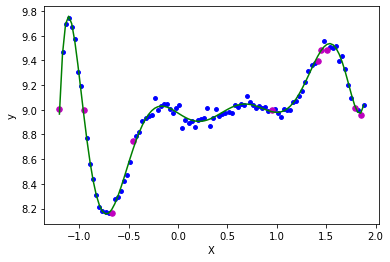

(array([ 8.97547675, -0.4938511 , -0.02974298,  5.43424352, -4.89995808,
        -7.20662444,  8.81990499,  1.10358338, -3.73607757,  1.01382973]),
 0.0005910737577133748,
 0.0005238645524446297)

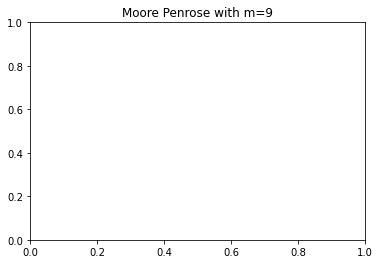

In [132]:
evaluate_moorepenrose(dataset,9)

In [16]:
def plotData(dataset):
    dataset = np.array(dataset)
    X = dataset[:,0]
    y = dataset[:,1]
    plt.scatter(X,y,color="b",marker='o',s=20)
    plt.ylabel('t')
    plt.xlabel('x')
    plt.title(f'Gaussian Noise Dataset n={SUBSET} points')
    plt.show
    #plt.savefig(f'Gaussian Noise Dataset_{SUBSET}.png',dpi=1200)

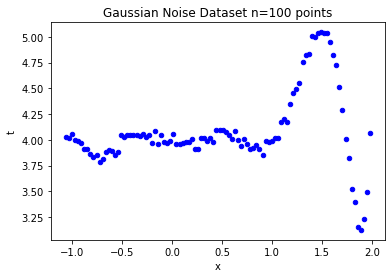

In [17]:
plotData(dataset)

In [240]:
def moorePenroseAnalysis(dataset):
    testerrlist = []
    trainerrlist = []
    for MAX_POWER in range(3,13):
        w,testerr,trainerr = evaluate_moorepenrose2(dataset,MAX_POWER)
        testerrlist.append(testerr)
        trainerrlist.append(trainerr)
    xa = np.arange(3,13)
    plt.clf()
    plt.plot(xa,trainerrlist,color='r',label="Training error")
    plt.plot(xa,testerrlist,color='b',label="Testing error")
    plt.legend()
    plt.savefig('Moore Penrose(Error vs m).png',dpi=1200)
    plt.show()

1e-12
1e-12
1e-12
1e-12
1e-12
1e-12
1e-12
1e-12
1e-12
1e-12


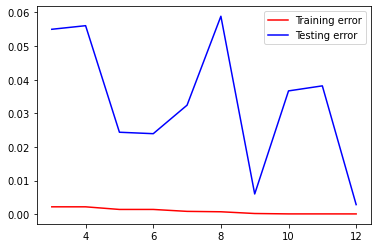

In [241]:
moorePenroseAnalysis(dataset)

In [209]:
def moorePenroseRegAnalysis(dataset):
    testerrlist = []
    trainerrlist = []
    global REGULARIZATION_LAMBDA
    for reg in [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]:
        REGULARIZATION_LAMBDA = reg
        w,testerr,trainerr = evaluate_moorepenrose2(dataset,9)
        testerrlist.append(testerr)
        trainerrlist.append(trainerr)
    xa = np.arange(-12,0)
    plt.clf()
    plt.plot(xa,trainerrlist,color='r',label="Training error")
    plt.plot(xa,testerrlist,color='b',label="Testing error")
    plt.legend()
    plt.xlabel("log(lambda)")
    plt.ylabel("Error")
    plt.title("Error vs Lambda")
    plt.savefig('Error vs Lambda.png',dpi=1200)
    plt.show()

1e-12
1e-11
1e-10
1e-09
1e-08
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1


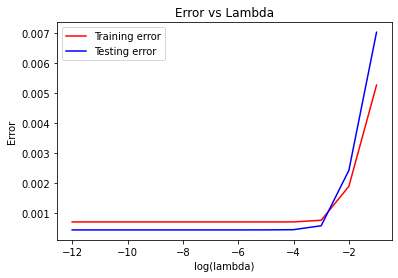

In [226]:
moorePenroseRegAnalysis(dataset)

In [18]:
def pseudoInv(X,t):
    pseudoInverse=np.linalg.pinv(X)
    weights=pseudoInverse @ t
    return(weights)

In [19]:
ds = np.array(dataset)
finw = pseudoInv(makeDesignMat(ds[:,0],9),ds[:,1])

In [230]:
def evaluate_moorepenrose2(dataset,MAX_POWER):
    dataset = np.array(dataset)
    trainDS = dataset[:18]
    testDS = dataset[18:]
    trainX = trainDS[:,0]
    trainY = trainDS[:,1]
    testX = testDS[:,0]
    testY = testDS[:,1]
    X = makeDesignMat(trainX,MAX_POWER)
    print(REGULARIZATION_LAMBDA)
    w = np.dot(np.linalg.inv(np.dot(X.transpose(),X) + REGULARIZATION_LAMBDA * np.identity(MAX_POWER+1) ),np.dot(X.transpose(),trainY))
    plt = plot_reg(trainX,trainY,testX,testY,w)
    plt.title(f"Moore Penrose with m={MAX_POWER}")
#         if j==0:
#             plt.savefig(f"Moore Penrose with m={MAX_POWER}.png",dpi=1200)
    trainerr = testError(trainX,trainY,w,MAX_POWER)
    testerr = testError(testX,testY,w,MAX_POWER)
    return w,testerr,trainerr

In [33]:
XX = makeDesignMat(ds[:,0],9)
pred = np.dot(XX,finw)
beta = len(ds[:,1])/(np.sum(np.square(pred-ds[:,1])))
1/beta

0.0013441315056887191

Mean of noise is: 1.0627942970131698e-13
Standard deviation of noise is: 0.036662399071647214
-0.07942198069926354 0.08833266771018389


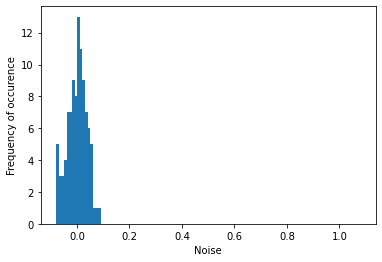

In [35]:
def getNoisePlot(trainX,trainY,w):
    trainX = makeDesignMat(trainX,MAX_POWER)
    preds = np.dot(trainX,w)
    noise = trainY-preds
    print(f"Mean of noise is: {np.mean(noise)}")
    print(f"Standard deviation of noise is: {np.std(noise)}")
    print(min(noise),max(noise))
    plt.clf()
    plt.hist(noise, bins=np.arange(noise.min(),noise.max()+1,0.01))
    plt.xlabel("Noise")
    plt.ylabel("Frequency of occurence")
getNoisePlot(ds[:,0],ds[:,1],finw)